In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
# Tensorflow imports
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, \
    multiply, concatenate, Flatten, Activation, dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')
sns.set(style='whitegrid', palette='deep', font_scale=1.2)

In [ ]:
!pip install keras-tcn

# Import keras-tcn api
from tcn import TCN, tcn_full_summary

In [3]:
# Block to load file depending if you are in Colab or in Jupyter
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    !nvidia-smi
    TF_CPP_MIN_LOG_LEVEL=2

    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(device_name))
    # get data
    !wget --no-check-certificate \
        https://www.dropbox.com/s/qbn9y5ooqxipxki/single_feature.csv?dl=0 \
        -O /tmp/Features.csv
        
    data = pd.read_csv('/tmp/Features.csv', parse_dates=['Timestamp'], index_col='Timestamp')
else:
    path_of_file = '../Data/single_feature.csv'
    data = pd.read_csv(path_of_file, parse_dates=['Timestamp'], index_col='Timestamp')

Running on CoLab
Wed Nov  4 14:34:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                       

In [4]:
def split_sequences_multivariate(sequences, n_steps=32):
    
    '''
    Split a multivariate sequence into samples for single feature prediction
    Taken and adapted from Machinelearningmastery.
    Split the training set into segments of a specified timestep
    and creates the labels.
    '''
    #n_steps = n_steps+1
    # Place the column of the feature to predict at the end of the dataset
    #sequences = np.concatenate([X_train, X_train[:,0].reshape(-1,1)],axis=1)
    
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    
    #print(np.shape(X),np.shape(y))
    return np.array(X), np.array(y)

def get_errors(model, train_X, test_X, train_y, test_y):
    
    train_predictions = model.predict(train_X)
    test_predictions = model.predict(test_X)
    
    MAE_train = abs(train_predictions - train_y).mean()
    MAE_test = abs(test_predictions - test_y).mean()
    if train_y.shape[1] == 3:
        mae_overall_train = abs(train_predictions-train_y).mean(axis=(1))
        mae_overall_test = abs(test_predictions-test_y).mean(axis=(1))
        mse_test = mean_squared_error(test_y, test_predictions)
        rmse_test = np.sqrt(mse_test)
        r2_test = r2_score(test_y, test_predictions)
    else:
        mae_overall_train = abs(train_predictions-train_y).mean(axis=(1,2))
        mae_overall_test = abs(test_predictions-test_y).mean(axis=(1,2))
        mse_test = mean_squared_error(test_y.reshape(-1,3), test_predictions.reshape(-1,3))
        r2_test = r2_score(test_y.reshape(-1,3), test_predictions.reshape(-1,3)) 

    rmse_test = np.sqrt(mse_test)
    return MAE_train, MAE_test, mae_overall_train, mae_overall_test, mse_test, r2_test, rmse_test

def plot_mae_overall(MAE_train, MAE_test, mae_overall_train, mae_overall_test, suptitle):
    
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(24,4))
    fig.suptitle(suptitle, y=1.02, fontsize=16.5)
    
    ax1.plot(mae_overall_train, label='MAE Train')
    ax1.set_title('MAE Train={}'.format(MAE_train))
    ax2.plot(mae_overall_test, label='MAE Test', color='teal')
    ax2.set_title('MAE Test={}'.format(MAE_test))
    fig.legend(loc='upper right')
    plt.tight_layout()

def plot_model(model, X, y, feature_index=0):

    prediction = model.predict(X)
    if prediction.shape[-1] == 1:
        pred_df = pd.DataFrame(data= np.concatenate((model.predict(X), y.reshape(-1,1)), axis=1), columns=['Prediction', 'True'])
    else:
        pred_df = pd.DataFrame(data= np.concatenate((model.predict(X)[:,feature_index].reshape(-1,1),
                                                     y[:,feature_index].reshape(-1,1)), axis=1), columns=['Prediction', 'True'])
    mse = mean_squared_error(y, prediction)
    rmse = np.sqrt(mse_test)
    r2 = r2_score(y, prediction)

    fig, ax1 = plt.subplots(1,1,figsize=(14,4))
    pred_df.plot(ax=ax1)
    plt.legend(loc='upper left')
    plt.title('Prediction and Truth rmse = {}, r2 score = {}'.format(np.round(rmse,4), np.round(r2,4)))    
    plt.tight_layout()

Lenght of Data 14688
Lenght of Train 11750


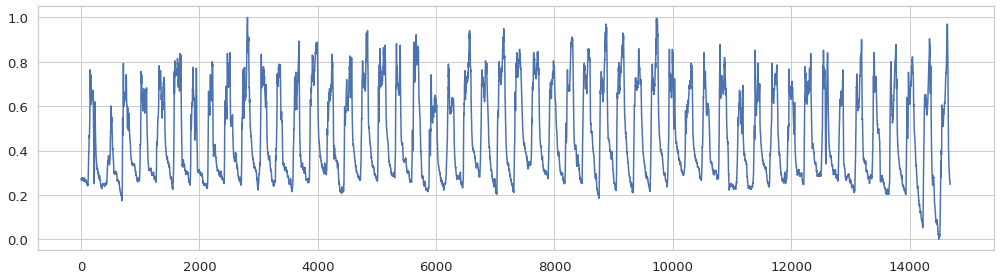

In [5]:
# The data is higly irregular so let's resample it to 10 min and take the mean
resampled = data.resample('5Min').mean()
resampled = resampled.fillna(resampled.bfill())
# Now let's take only a slice of it

init_date = '2019-03'
train_end_date = '2019-10-25'
end_date = '2019-04-20'
#Separate Train and test
train_data = resampled[init_date:end_date]

train_ratio = 0.8
train_len = int(train_ratio*len(train_data))
scaler = MinMaxScaler()
normalized_train = scaler.fit_transform(train_data)
print('Lenght of Data {}'.format(len(normalized_train)))
print('Lenght of Train {}'.format(train_len))

fig, ax1 = plt.subplots(1,1, figsize=(14,4))
ax1.plot(normalized_train[:,0])
plt.tight_layout()

### Arguments
```python
TCN(nb_filters=64, kernel_size=2, nb_stacks=1, dilations=[1, 2, 4, 8, 16, 32], padding='causal', use_skip_connections=False, dropout_rate=0.0, return_sequences=True, activation='relu', kernel_initializer='he_normal', use_batch_norm=False, **kwargs)
```
- nb_filters: Integer. The number of filters to use in the convolutional layers. Would be similar to units for LSTM.
- kernel_size: Integer. The size of the kernel to use in each convolutional layer.
- dilations: List. A dilation list. Example is: [1, 2, 4, 8, 16, 32, 64].
- nb_stacks: Integer. The number of stacks of residual blocks to use.
- padding: String. The padding to use in the convolutions. 'causal' for a causal network (as in the original implementation) and 'same' for a non-causal network.
- use_skip_connections: Boolean. If we want to add skip connections from input to each residual block.
- return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence.
- dropout_rate: Float between 0 and 1. Fraction of the input units to drop.
- activation: The activation used in the residual blocks o = activation(x + F(x)).
- kernel_initializer: Initializer for the kernel weights matrix (Conv1D).
- use_batch_norm: Whether to use batch normalization in the residual layers or not.
- kwargs: Any other arguments for configuring parent class Layer. For example "name=str", Name of the model. Use unique names when using multiple TCN.

### Input shape
3D tensor with shape (batch_size, timesteps, input_dim).

timesteps can be None. This can be useful if each sequence is of a different length: Multiple Length Sequence Example.

### Output shape
- if return_sequences=True: 3D tensor with shape (batch_size, timesteps, nb_filters).
- if return_sequences=False: 2D tensor with shape (batch_size, nb_filters).

### Supported task types
- Regression (Many to one) e.g. adding problem
- Classification (Many to many) e.g. copy memory task
- Classification (Many to one) e.g. sequential mnist task
- For a Many to Many regression, a cheap fix for now is to change the number of units of the final Dense layer.

In [84]:
timesteps = 128
n_features = 3
batch_size = 256

train_X, train_y = split_sequences_multivariate(normalized_train[:train_len], n_steps=timesteps)
test_X, test_y = split_sequences_multivariate(normalized_train[train_len:], n_steps=timesteps)

In [80]:
class myCallback(tf.keras.callbacks.Callback):
  def __init__(self, mae=0.027):
    super(myCallback, self).__init__()
    self.mae = mae

  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_mae') <= self.mae):
      print("\nReached 0.027 mae so cancelling training!")
      self.model.stop_training = True


Reached 0.027 mae so cancelling training!
Mean Absolute Error in Testing  0.028671829183176047
Mean Squared Error in Testing  0.002209068255585087
R2 Score in Testing  0.9818950630726536
Root Mean Squared Error in Testing  0.0470007261176366


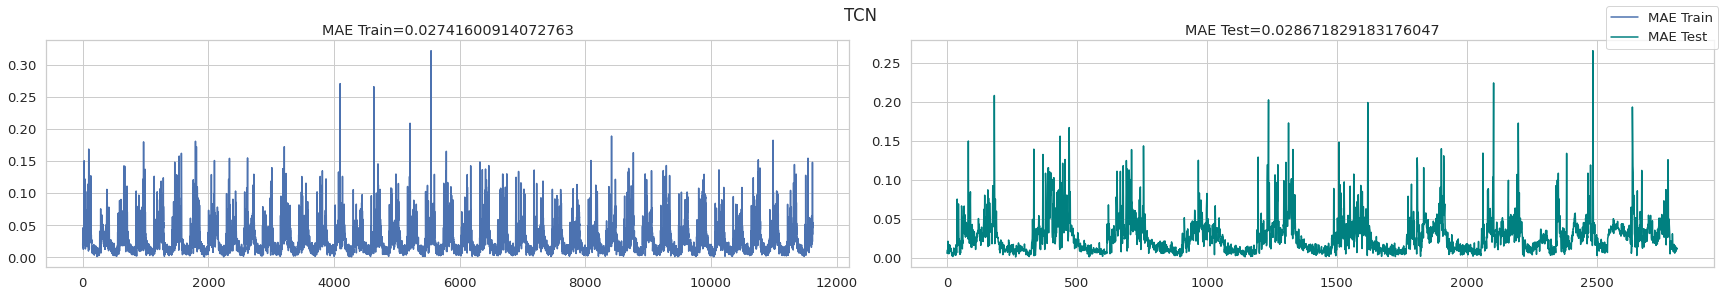

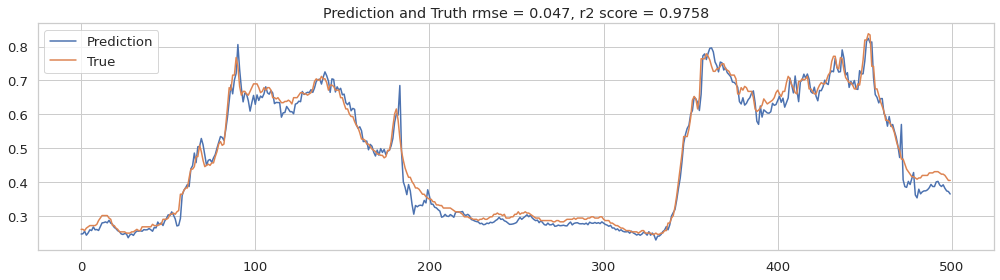

In [88]:
batches = None
epochs = 120

tcn_input = Input(batch_shape=(batches, timesteps, n_features))

tcn_layer = TCN(return_sequences=False, activation='relu', dropout_rate=0.1, nb_filters=128)(tcn_input)  # The TCN layers are here.
output_layer = Dense(n_features)(tcn_layer)

model = tf.keras.models.Model(inputs=[tcn_input], outputs=[output_layer])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

my_callback = myCallback()

#tcn_full_summary(model, expand_residual_blocks=True)

history = model.fit(train_X, train_y, epochs=epochs,
                    validation_split=0.2, verbose=0,
                    callbacks=[my_callback],
                    batch_size=batch_size)

history_df = pd.DataFrame(history.history, columns=['loss','val_loss','mae', 'val_mae'])

MAE_train, MAE_test, mae_overall_train, mae_overall_test, mse_test, r2_test, rmse_test = \
get_errors(model, train_X, test_X, train_y, test_y)

plot_mae_overall(MAE_train, MAE_test, mae_overall_train, mae_overall_test, suptitle='TCN')

plot_model(model, test_X[:500], test_y[:500], feature_index=0)

print('Mean Absolute Error in Testing ',MAE_test)
print('Mean Squared Error in Testing ',mse_test)
print('R2 Score in Testing ',r2_test)
print('Root Mean Squared Error in Testing ',rmse_test)

In [89]:
# next_bath starts with the last batch of the training set
next_batch = train_X[-1, :, :]
predictions_forecast = []
next_step_truth_list = []
counter = 0
error_stack = []
n_timesteps_out = 1

# Repeat a number of future timesteps
for ii in range(500):
  # Reshape to 3D for prediction
  next_step_pred = model.predict(next_batch.reshape(1, timesteps, n_features))
  # Reshape to 2D
  next_step_pred = next_step_pred.reshape(n_timesteps_out, n_features)

  # the real values are in normalized_train. Starting from train_len is the testing data set
  # which is the continuation (or truth) of the values predicted in from the last training batch
  # but only n_timesteps_out amounth. We have to shift the timesteps in validation by n_timesteps_out times 
  next_step_truth = normalized_train[train_len:][ii * n_timesteps_out : n_timesteps_out*(ii+1)]
  next_step_truth_list.append(next_step_truth)
  # calculate error
  error_temp = abs(next_step_truth[:,0] - next_step_pred[:,0])
  error_vmppt = abs(next_step_truth[:,1] - next_step_pred[:,1])
  error_vpanel = abs(next_step_truth[:,2] - next_step_pred[:,2])
  error = abs(next_step_truth - next_step_pred).mean()

  # Stack the rolling MAE for counting the points
  # Next we have to ensamble the data with the points and 
  # not with the sequences but for now let's just count
  error_temp = error_temp.reshape(-1,1).mean(axis=1)
  error_stack.append(error_temp)

  if error > 0.05:
    # Save the predicted values
    predictions_forecast.append(next_step_truth)
    # Take the next batch for predcition
    next_batch = np.row_stack([next_batch[n_timesteps_out:], next_step_truth])
    counter+=1
  else:
    # Save the predicted values
    predictions_forecast.append(next_step_pred)
    # Take the next batch for predcition
    next_batch = np.row_stack([next_batch[n_timesteps_out:], next_step_pred])

    #print('MAE Temp {}, MAE VMPPT {}, MAE VPAN {}, MAE {}'.format(error_temp, error_vmppt, error_vpanel, error))  

Number of Sequences to transmit  133


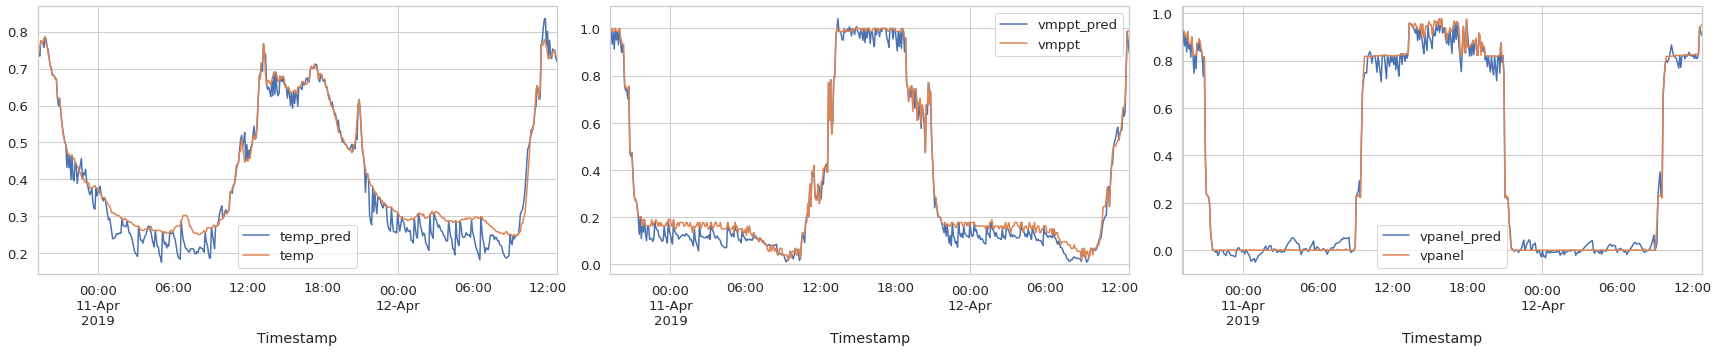

In [90]:
#--------------- this part is for plotting and create dataframes----------------------

print('Number of Sequences to transmit ',counter)

# reshape predictions
predictions_forecast = np.array(predictions_forecast).reshape(-1,3)
# reshape real values
forecast_truth = np.array(next_step_truth_list).reshape(-1,3)
# Stack error and real values
error_forecast = np.column_stack([predictions_forecast,forecast_truth])
# create dataframe with truth and error
error_forecast_df = pd.DataFrame(data=error_forecast, columns=['temp_pred','vmppt_pred','vpanel_pred','temp','vmppt','vpanel'])
# Set date index for dataframe taking
error_forecast_df = error_forecast_df.set_index(train_data[train_len:][:error_forecast_df.shape[0]].index)

# Create dataframe of errors > threshold
# error stack is the MAE calculated above and stacked
err = np.array(error_stack).reshape(-1,1)
err_df = pd.DataFrame(err, columns=['error'])
err_df = err_df.loc[err_df['error']>0.05]

fig, axx = plt.subplots(1, 3, figsize=(24,5))
error_forecast_df[['temp_pred','temp']].plot(ax=axx[0])
error_forecast_df[['vmppt_pred','vmppt']].plot(ax=axx[1])
error_forecast_df[['vpanel_pred','vpanel']].plot(ax=axx[2])
plt.tight_layout()